In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from google.colab import drive

# Mount Google Drive if in Colab
try:
    drive.mount('/content/drive')
    print("Google Drive mounted successfully")
except:
    print("Not running in Colab or Drive already mounted")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully


In [4]:
BASE_PATH = '/content/drive/MyDrive/Detection'
TRAIN_PATH = os.path.join(BASE_PATH, 'train')
TEST_PATH = os.path.join(BASE_PATH, 'test')



In [5]:
# Configuration
BATCH_SIZE = 16
IMAGE_SIZE = [180, 180]
EPOCHS = 25
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Get all file paths
train_normal_dir = os.path.join(TRAIN_PATH, 'NORMAL')
train_pneumonia_dir = os.path.join(TRAIN_PATH, 'PNEUMONIA')

train_normal_files = [os.path.join(train_normal_dir, filename) for filename in os.listdir(train_normal_dir) if filename.endswith('.jpeg') or filename.endswith('.jpg') or filename.endswith('.png')]
train_pneumonia_files = [os.path.join(train_pneumonia_dir, filename) for filename in os.listdir(train_pneumonia_dir) if filename.endswith('.jpeg') or filename.endswith('.jpg') or filename.endswith('.png')]

all_files = train_normal_files + train_pneumonia_files
train_filenames, val_filenames = train_test_split(all_files, test_size=0.2)

# Count images by category
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print("Normal images count in training set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))

# Create TensorFlow datasets
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

TRAIN_IMG_COUNT = len(train_filenames)
print("Training images count: " + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = len(val_filenames)
print("Validating images count: " + str(VAL_IMG_COUNT))

# Define a function to get the label from a file path
def get_label(file_path):
    # Extract label from file path
    parts = tf.strings.split(file_path, os.path.sep)
    # Check if the part contains "PNEUMONIA"
    return tf.cast(tf.strings.regex_full_match(parts[-2], ".*PNEUMONIA.*"), tf.float32)

def decode_img(img):
    # Convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # Resize the image to the desired size
    return tf.image.resize(img, IMAGE_SIZE)

def process_path(file_path):
    # Get label (converted to a tensor with static shape)
    label = get_label(file_path)
    # Load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

# Map dataset processing
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

# Test dataset (assuming similar structure)
test_files = []
test_normal_dir = os.path.join(TEST_PATH, 'NORMAL')
test_pneumonia_dir = os.path.join(TEST_PATH, 'PNEUMONIA')

if os.path.exists(test_normal_dir):
    test_files.extend([os.path.join(test_normal_dir, filename) for filename in os.listdir(test_normal_dir) if filename.endswith('.jpeg') or filename.endswith('.jpg') or filename.endswith('.png')])
if os.path.exists(test_pneumonia_dir):
    test_files.extend([os.path.join(test_pneumonia_dir, filename) for filename in os.listdir(test_pneumonia_dir) if filename.endswith('.jpeg') or filename.endswith('.jpg') or filename.endswith('.png')])

test_list_ds = tf.data.Dataset.from_tensor_slices(test_files)
TEST_IMAGE_COUNT = len(test_files)
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(f"Test images count: {TEST_IMAGE_COUNT}")

def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    # This is a small dataset, only load it once, and keep it in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

# Verify the shape of our data
for images, labels in train_ds.take(1):
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print("Sample labels:", labels.numpy())

Normal images count in training set: 1098
Pneumonia images count in training set: 3084
Training images count: 4182
Validating images count: 1046
Test images count: 626
Images shape: (16, 180, 180, 3)
Labels shape: (16,)
Sample labels: [1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 0. 1.]


Weight for class 0: 1.90
Weight for class 1: 0.68
Epoch 1/25
261/261 ━━━━━━━━━━━━━━━━━━━━ 107s 277ms/step - accuracy: 0.6855 - loss: 0.5896 - precision: 0.8884 - recall: 0.6640 - val_accuracy: 0.7654 - val_loss: 0.6193 - val_precision: 0.7654 - val_recall: 1.0000
Epoch 2/25
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.8988 - loss: 0.2450 - precision: 0.9741 - recall: 0.8884 - val_accuracy: 0.7654 - val_loss: 1.4950 - val_precision: 0.7654 - val_recall: 1.0000
Epoch 3/25
261/261 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.9280 - loss: 0.1794 - precision: 0.9784 - recall: 0.9237 - val_accuracy: 0.8173 - val_loss: 0.4865 - val_precision: 0.8075 - val_recall: 1.0000
Epoch 4/25
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.9370 - loss: 0.1691 - precision: 0.9800 - recall: 0.9334 - val_accuracy: 0.9433 - val_loss: 0.1314 - val_precision: 0.9434 - val_recall: 0.9849
Epoch 5/25
261/261 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.9248 - loss: 0.1770 - precision: 0

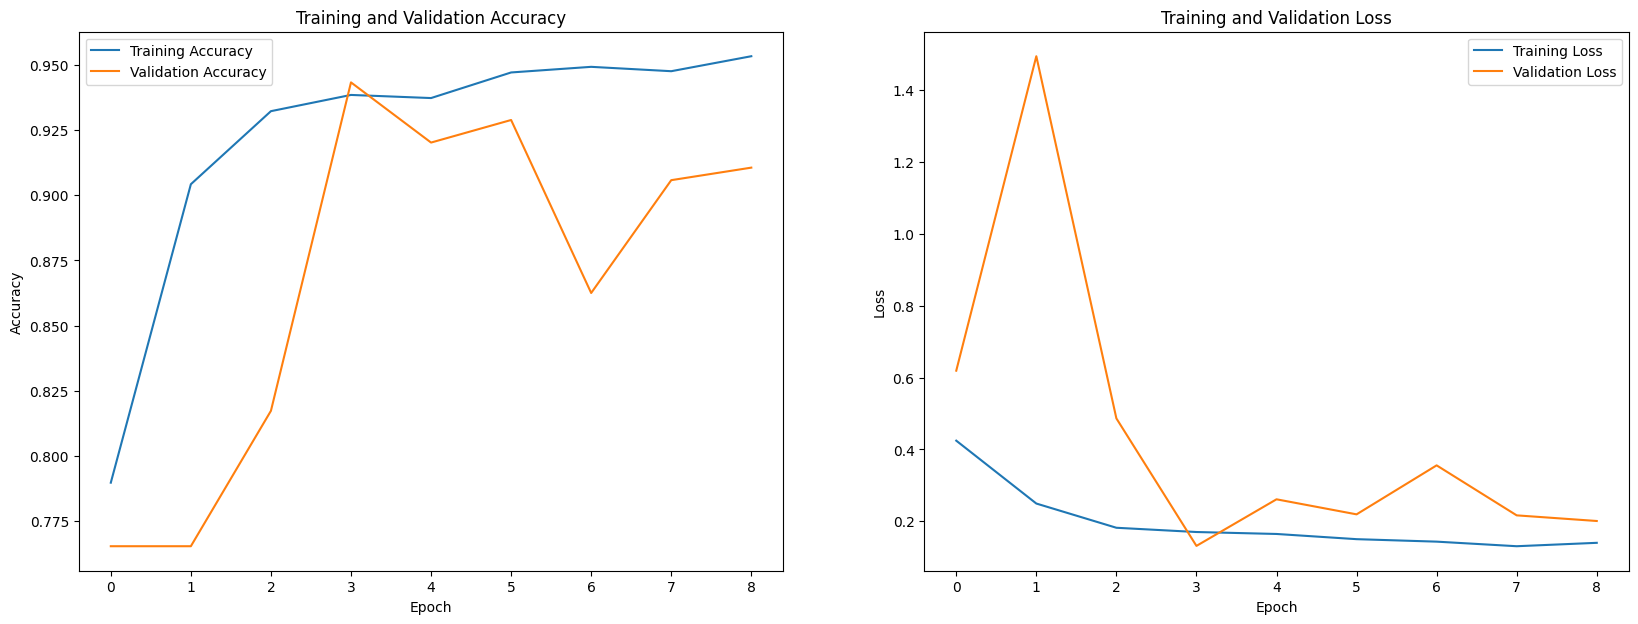

Model saved to /content/drive/MyDrive/Detection/pneumonia_detection_model.h5


In [6]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])

    return block

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])

    return block

def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),

        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),

        conv_block(32),
        conv_block(64),

        conv_block(128),
        tf.keras.layers.Dropout(0.2),

        conv_block(256),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),

        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    return model

# Class weighting to handle imbalance
initial_bias = np.log([COUNT_PNEUMONIA/COUNT_NORMAL])
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

# Build and compile model
model = build_model()

# Add early stopping to save time
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

METRICS = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=METRICS
)

# Train model
history = model.fit(
    train_ds,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_ds,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    class_weight=class_weight,
    callbacks=[early_stopping]
)

# Evaluate on test set
test_results = model.evaluate(test_ds, steps=TEST_IMAGE_COUNT // BATCH_SIZE)
print("Test loss, accuracy, precision, recall:", test_results)

# Plot training history
def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))

    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.set_title('Training and Validation Accuracy')
    ax1.legend()

    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.set_title('Training and Validation Loss')
    ax2.legend()

    plt.show()

plot_history(history)

# Save the model
model.save(os.path.join(BASE_PATH, 'pneumonia_detection_model.h5'))
print("Model saved to", os.path.join(BASE_PATH, 'pneumonia_detection_model.h5'))